In [1]:
import numpy as np
import pandas as pd
import shapely.wkt
import shapely.ops
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
links_df = pd.read_csv('../network_inputs/osm_edges.csv')
links_gdf = gpd.GeoDataFrame(links_df, crs=4326, geometry=links_df['geometry'].map(shapely.wkt.loads))
roads_gdf = links_gdf.copy()
links_gdf = links_gdf.to_crs(26910)
links_gdf['start_lon_proj'] = links_gdf['geometry'].apply(lambda x: x.coords[0][0])
links_gdf['start_lat_proj'] = links_gdf['geometry'].apply(lambda x: x.coords[0][1])
links_gdf['end_lon_proj'] = links_gdf['geometry'].apply(lambda x: x.coords[-1][0])
links_gdf['end_lat_proj'] = links_gdf['geometry'].apply(lambda x: x.coords[-1][1])
# links_df

FileNotFoundError: [Errno 2] File t_stats/t_stats_scenrs0_f1_c0_vphh2_vist300.csv does not exist: 't_stats/t_stats_scenrs0_f1_c0_vphh2_vist300.csv'

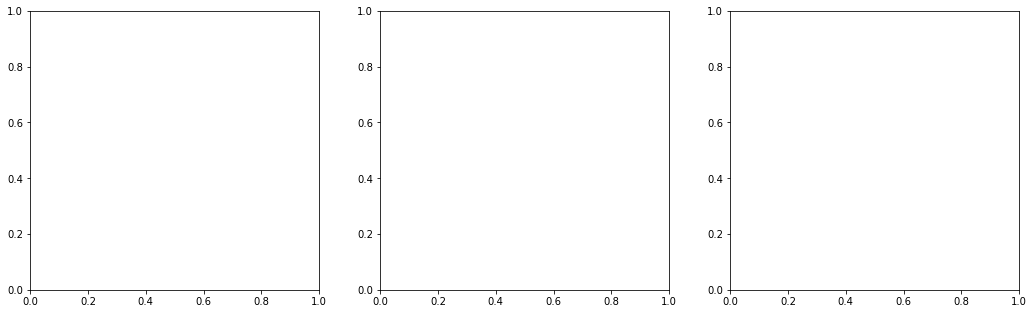

In [3]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(pad=3)

rs = 0
vphh = 2
vist = 300
color = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for commscen in [0, 1, 2]:
    c = next(color)
    for firescen in [1, 2, 3]:
        try:
            t_stats = pd.read_csv('t_stats/t_stats_scenrs{}_f{}_c{}_vphh{}_vist{}.csv'.format(rs, firescen, commscen, vphh, vist))
        except FileNotFoundError:
            t_stats = pd.read_csv('t_stats/t_stats_scenrs{}_f{}_c{}_vphh{}_vist{}.csv'.format(rs, firescen, commscen, vphh, vist))
            
        print(firescen, commscen, 
              t_stats.loc[t_stats['t'].isin([3600*2, 3600*5, 3600*10]), 'arr_local'].values/1200,
              t_stats.loc[t_stats['t'].isin([3600*2, 3600*5, 3600*10]), 'arr_visitor'].values/300)
            
        ax[firescen-1].plot(t_stats['t']/3600, t_stats['arr'], c=c, label='comm. {}'.format(commscen+1))
#         ax[firescen-1].plot(t_stats['t']/3600, t_stats['predepart'], label=commscen)
#         ax[firescen-1].plot(t_stats['t']/3600, t_stats['stay'], c=c)
#         ax[firescen-1].plot(t_stats['t']/3600, t_stats['see_fire'], label=commscen)
        ax[firescen-1].set_xlabel('hour')
        ax[firescen-1].set_ylabel('reaching destination')
        ax[firescen-1].set_title('Fire scenario {}'.format(firescen))
plt.legend()

In [4]:
def add_geom(rs=None, firescen=None, commscen=None, vphh=None, vist=None, t=None):
    link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
    link_stats = pd.merge(link_stats, links_df[['edge_id_igraph', 'geometry']], how='left', left_on='link_id', right_on='edge_id_igraph')
#     print(link_stats[link_stats['q']>0].shape)
    link_stats.to_csv('../visualization_outputs/link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))

for t in range(6000, 18000, 1200):
    add_geom(rs=0, firescen=3, commscen=0, vphh=2, vist=300, t=t)
    add_geom(rs=0, firescen=3, commscen=2, vphh=2, vist=300, t=t)

FileNotFoundError: [Errno 2] File link_stats/link_stats_rs0_f3_c0_vphh2_vist300_t6000.csv does not exist: 'link_stats/link_stats_rs0_f3_c0_vphh2_vist300_t6000.csv'

In [4]:
from shapely.geometry import Point

closed_links = []
def get_road_closure(firescen=1):
    ### flame length
    flame_length = pd.read_csv(open('../demand_inputs/flamelength/flame_length_point_4326/point_firescen{}.csv'.format(firescen)))
    flame_length = gpd.GeoDataFrame(flame_length, crs='epsg:4326', geometry=[Point(xy) for xy in zip(flame_length.lon, flame_length.lat)]).to_crs('epsg:26910')
    flame_length['lon'], flame_length['lat'] = flame_length['geometry'].x, flame_length['geometry'].y
    
    for hour in range(1, 11):
        flame_length_hour = flame_length.loc[(flame_length['t_hour']==hour) & (flame_length['flame_length']>2)]
        print('fire {}, hour {}, flame point cnts {}'.format(firescen, hour, flame_length_hour.shape))
        if flame_length_hour.shape[0]==0:
            continue

        for link in links_gdf.itertuples():
            end_lon_proj, start_lon_proj, end_lat_proj, start_lat_proj = getattr(link, 'end_lon_proj'), getattr(link, 'start_lon_proj'), getattr(link, 'end_lat_proj'), getattr(link, 'start_lat_proj')
            l13 = np.vstack((flame_length_hour['lon'] - start_lon_proj, flame_length_hour['lat'] - start_lat_proj)).T
            l23 = np.vstack((flame_length_hour['lon'] - end_lon_proj, flame_length_hour['lat'] - end_lat_proj)).T
            l12 = (end_lon_proj - start_lon_proj, end_lat_proj - start_lat_proj)
            l21 = (start_lon_proj - end_lon_proj, start_lat_proj - end_lat_proj)
            ### line distance
            line_dist = np.abs(np.matmul(l13, (l12[-1], -l12[0]))) / np.linalg.norm(l12)
            ### start_dist_array
            start_node_distance = np.linalg.norm(l13, axis=1)
            start_node_angle = np.matmul(l13, l12)
            ### end_dist_array
            end_node_distance = np.linalg.norm(l23, axis=1)
            end_node_angle = np.matmul(l23, l21)
            point_line_dist = np.where(start_node_angle<0, start_node_distance,
                                        np.where(end_node_angle<0, end_node_distance, line_dist))
            if np.min(point_line_dist) < 20: ### within 20=(1.414*30/2) m of the cell centroid. Cell width ~= 30m
                closure_status = 'closed'
                closed_links.append([firescen, hour, getattr(link, 'edge_id_igraph')])

firescen=3
get_road_closure(firescen)
closed_links_df = pd.DataFrame(closed_links, columns=['firescen', 'hour', 'link_id'])
closed_links_df.to_csv('../demand_inputs/closed_links/closed_links_firescen{}.csv'.format(firescen), index=False)
closed_links_df.head()

fire 3, hour 1, flame point cnts (47, 5)
fire 3, hour 2, flame point cnts (203, 5)
fire 3, hour 3, flame point cnts (381, 5)
fire 3, hour 4, flame point cnts (671, 5)
fire 3, hour 5, flame point cnts (903, 5)
fire 3, hour 6, flame point cnts (1069, 5)
fire 3, hour 7, flame point cnts (1151, 5)
fire 3, hour 8, flame point cnts (1197, 5)
fire 3, hour 9, flame point cnts (1212, 5)
fire 3, hour 10, flame point cnts (1221, 5)


,firescen,hour,link_id
0,3,2,266
1,3,2,267
2,3,2,499
3,3,2,500
4,3,2,525


In [6]:
rs, firescen, vphh, vist = 0, 2, 2, 300
for t in range(1200, 36000, 1200):
    fig, ax = plt.subplots(1,3, figsize=(15,10))
    for commscen in [0, 1, 2]:
        ### base
        roads_plot = roads_gdf.to_crs(26910).plot(ax=ax[commscen], lw=0.5, color='gray', alpha=0.5)

        ### closed
    #     closed_links = pd.read_csv('../demand_inputs/closed_links/closed_links_firescen{}.csv'.format(firescen))
    #     closed_links = closed_links[closed_links['hour']==(t//3600)]
    #     closed_links = pd.merge(roads_gdf[['edge_id_igraph', 'geometry']], closed_links, how='inner', right_on='link_id', left_on='edge_id_igraph')
    #     closed_plot = closed_links.to_crs(26910).plot(ax=ax[commscen], lw=5, color=[1,0,0,0.2])

        ### flame
        flame_length = pd.read_csv(open('../demand_inputs/flamelength/flame_length_point_4326/point_firescen{}.csv'.format(firescen)))
        flame_length = gpd.GeoDataFrame(flame_length, crs='epsg:4326', geometry=[Point(xy) for xy in zip(flame_length.lon, flame_length.lat)])
        flame_plot = flame_length[(flame_length['t_hour']==(t//3600)) & (flame_length['flame_length']>2)].to_crs(26910).plot(ax=ax[commscen], lw=5, color='salmon', alpha=0.2)

        try:
            link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_nodetour_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
        except FileNotFoundError:
            link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_noclosure_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
        link_stats = pd.merge(roads_gdf[['edge_id_igraph', 'length', 'geometry']], link_stats, how='inner', right_on='link_id', left_on='edge_id_igraph')
        vehs_geom = link_stats[(link_stats['q']+link_stats['r'])>0].copy()
        vehs_geom['geometry'] = vehs_geom.to_crs(26910).apply(lambda x: shapely.ops.substring( x['geometry'], 1-(x['q']+x['r'])*8/x['length'], 1, normalized=True), axis=1)
        vehs_plot = vehs_geom.plot(ax=ax[commscen], lw=3, color='purple')
#         print(queues_geom)
#         break

        ax[commscen].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        ax[commscen].set_xlim([525000, 528500])
        ax[commscen].set_ylim([4194000, 4199230])
        if t>=3600: ax[commscen].set_title("{} hr {} min; comm. scen. {}".format(t//3600, t%3600, commscen + 1))
        else: ax[commscen].set_title("{} min, comm. scenario {}".format(int(t/60), commscen + 1))
    plt.savefig('../visualization_outputs/link_occupancy_images/rs{}_f{}_vphh{}_vist{}_t{}.png'.format(rs, firescen, vphh, vist, t))
    plt.close()

/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/bin

In [ ]:
import imageio

rs, firescen, vphh, vist = 0, 2, 2, 300
images = []
for t in range(1200, 36000, 1200):
    images.append(imageio.imread('../visualization_outputs/link_occupancy_images/rs{}_f{}_vphh{}_vist{}_t{}.png'.format(rs, firescen, vphh, vist, t)))
imageio.mimsave('../visualization_outputs/link_occupancy_images/rs{}_f{}_vphh{}_vist{}.gif'.format(rs, firescen, vphh, vist), images, fps=2)

In [13]:
rs, firescen, vphh, vist = 0, 2, 2, 300
for t in range(1200, 36000, 1200):
    fig, ax = plt.subplots(1,1, figsize=(10,20))
    for commscen in [2]:
        ### base
        roads_plot = roads_gdf.to_crs(26910).plot(ax=ax, lw=0.5, color='gray', alpha=0.5)

        ### flame
        flame_length = pd.read_csv(open('../demand_inputs/flamelength/flame_length_point_4326/point_firescen{}.csv'.format(firescen)))
        flame_length = gpd.GeoDataFrame(flame_length, crs='epsg:4326', geometry=[Point(xy) for xy in zip(flame_length.lon, flame_length.lat)])
        flame_plot = flame_length[(flame_length['t_hour']==(t//3600)) & (flame_length['flame_length']>2)].to_crs(26910).plot(ax=ax, lw=5, color='salmon', alpha=0.2)

        try:
            link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_nodetour_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
        except FileNotFoundError:
            link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_noclosure_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
        link_stats = pd.merge(roads_gdf[['edge_id_igraph', 'length', 'geometry']], link_stats, how='inner', right_on='link_id', left_on='edge_id_igraph')
        vehs_geom = link_stats[(link_stats['q']+link_stats['r'])>0].copy()
        vehs_geom['geometry'] = vehs_geom.to_crs(26910).apply(lambda x: shapely.ops.substring( x['geometry'], 1-(x['q']+x['r'])*8/x['length'], 1, normalized=True), axis=1)
        vehs_plot = vehs_geom.plot(ax=ax, lw=3, color='purple')

        ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        ax.set_xlim([525000, 528500])
        ax.set_ylim([4194000, 4199230])
        if t>=3600: ax.set_title("{} hr {} min; comm. scen. {}".format(t//3600, (t%3600)//60, commscen + 1), fontsize=20)
        else: ax.set_title("{} min; comm. scen. {}".format(int(t/60), commscen + 1), fontsize=20)
    plt.savefig('../visualization_outputs/link_occupancy_images/comm2_rs{}_f{}_vphh{}_vist{}_t{}.png'.format(rs, firescen, vphh, vist, t), dpi=300)
    plt.close()

/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
